In [2]:
import os
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

# === CONFIG ===
NUM_LANDMARKS = 71
velocity_base_path = {
    "Non-suspicious": [
        "transformed/velocity.npy/Train/Non-suspicious",
        "transformed/velocity.npy/Val/Non-suspicious",
        "transformed/velocity.npy/Test/Non-suspicious"
    ],
    "Suspicious": [
        "transformed/velocity.npy/Train/Suspicious",
        "transformed/velocity.npy/Val/Suspicious",
        "transformed/velocity.npy/Test/Suspicious"
    ]
}


# === Prepare structure to store per-landmark velocity values ===
velocity_data = {i: {"Non-suspicious": [], "Suspicious": []} for i in range(NUM_LANDMARKS)}

# === Load and process each .npy file ===
for label, paths in velocity_base_path.items():
    for path in paths:
        for file in os.listdir(path):
            if file.endswith(".npy"):
                full_path = os.path.join(path, file)
                try:
                    data = np.load(full_path)
                    magnitude = np.linalg.norm(data, axis=-1)
                    avg_magnitude = magnitude.mean(axis=0)
                    for i in range(NUM_LANDMARKS):
                        velocity_data[i][label].append(avg_magnitude[i])
                except Exception as e:
                    print(f"Error processing {file}: {e}")

# === Run ANOVA per landmark ===
anova_results = []

for i in range(NUM_LANDMARKS):
    group_ns = velocity_data[i]["Non-suspicious"]
    group_s = velocity_data[i]["Suspicious"]
    if len(group_ns) > 1 and len(group_s) > 1:
        f_stat, p_val = f_oneway(group_ns, group_s)
        result = {
            "Landmark Index": i,
            "F-statistic": round(f_stat, 4),
            "p-value": round(p_val, 5),
            "Mean Velocity (Non-suspicious)": round(np.mean(group_ns), 5),
            "Mean Velocity (Suspicious)": round(np.mean(group_s), 5),
            "Min Velocity (Non-suspicious)": round(np.min(group_ns), 5),
            "Max Velocity (Non-suspicious)": round(np.max(group_ns), 5),
            "Min Velocity (Suspicious)": round(np.min(group_s), 5),
            "Max Velocity (Suspicious)": round(np.max(group_s), 5),
            "Significant (p<0.05)": p_val < 0.05
        }
        anova_results.append(result)


# === Convert to DataFrame and Save ===
df = pd.DataFrame(anova_results)
df.sort_values(by="p-value", inplace=True)
df.to_csv("anova_velocity_results.csv", index=False)

print("ANOVA complete. Results saved to anova_velocity_results.csv.")


ANOVA complete. Results saved to anova_velocity_results.csv.


In [4]:
import os
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

# === CONFIG ===
NUM_LANDMARKS = 71
motion_base_path = {
    "Non-suspicious": [
        "transformed/motion.npy/Train/Non-suspicious",
        "transformed/motion.npy/Val/Non-suspicious",
        "transformed/motion.npy/Test/Non-suspicious"
    ],
    "Suspicious": [
        "transformed/motion.npy/Train/Suspicious",
        "transformed/motion.npy/Val/Suspicious",
        "transformed/motion.npy/Test/Suspicious"
    ]
}

# === Prepare storage for motion magnitudes per landmark ===
motion_data = {i: {"Non-suspicious": [], "Suspicious": []} for i in range(NUM_LANDMARKS)}

# === Load and compute mean motion magnitude ===
for label, paths in motion_base_path.items():
    for path in paths:
        for file in os.listdir(path):
            if file.endswith(".npy"):
                full_path = os.path.join(path, file)
                try:
                    data = np.load(full_path)  # shape: (T, 71, 2)
                    magnitude = np.linalg.norm(data, axis=-1)  # (T, 71)
                    avg_magnitude = magnitude.mean(axis=0)  # (71,)
                    for i in range(NUM_LANDMARKS):
                        motion_data[i][label].append(avg_magnitude[i])
                except Exception as e:
                    print(f"Error processing {file}: {e}")

# === Perform ANOVA per landmark ===
anova_results = []

for i in range(NUM_LANDMARKS):
    group_ns = motion_data[i]["Non-suspicious"]
    group_s = motion_data[i]["Suspicious"]
    if len(group_ns) > 1 and len(group_s) > 1:
        f_stat, p_val = f_oneway(group_ns, group_s)
        result = {
            "Landmark Index": i,
            "F-statistic": round(f_stat, 4),
            "p-value": round(p_val, 5),
            "Mean Motion (Non-suspicious)": round(np.mean(group_ns), 5),
            "Mean Motion (Suspicious)": round(np.mean(group_s), 5),
            "Min Motion (Non-suspicious)": round(np.min(group_ns), 5),
            "Max Motion (Non-suspicious)": round(np.max(group_ns), 5),
            "Min Motion (Suspicious)": round(np.min(group_s), 5),
            "Max Motion (Suspicious)": round(np.max(group_s), 5),
            "Significant (p<0.05)": p_val < 0.05
        }
        anova_results.append(result)

# === Save to CSV ===
df = pd.DataFrame(anova_results)
df.sort_values(by="F-statistic", inplace=True)
df.to_csv("anova_motion_results.csv", index=False)

print("ANOVA on motion complete. Results saved to anova_motion_results.csv.")


ANOVA on motion complete. Results saved to anova_motion_results.csv.


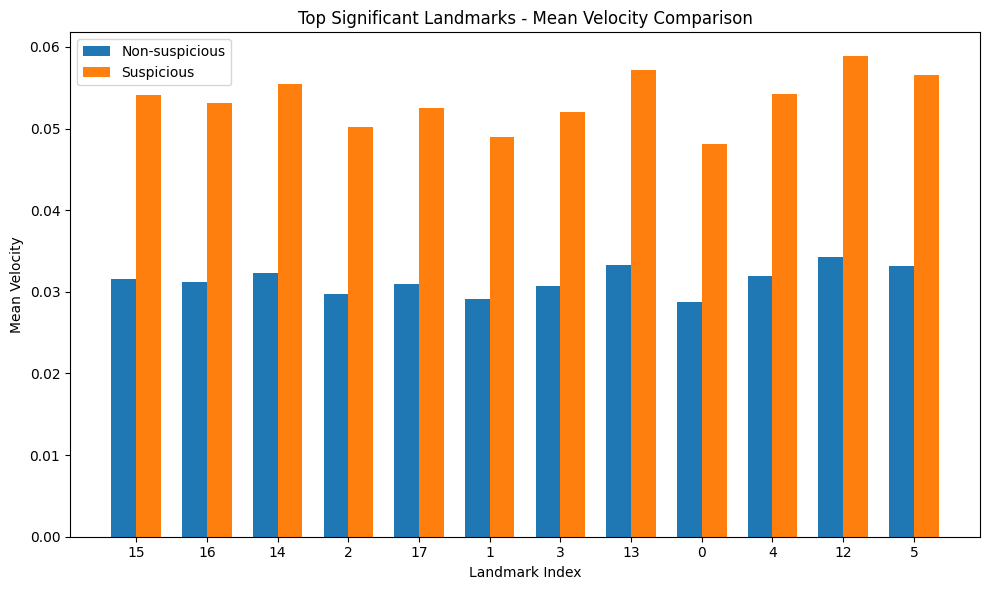

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Load the CSV ===
df = pd.read_csv("anova_velocity_results.csv")

# === Strip leading/trailing spaces in column names (fixes KeyError) ===
df.columns = df.columns.str.strip()

# === Select top N most significant landmarks ===
top_n = 12
top_landmarks = df.nsmallest(top_n, "F-statistic")

# === Bar Plot to Compare Velocity ===
landmark_indices = top_landmarks["Landmark Index"].astype(str)

motion_ns = top_landmarks["Mean Velocity (Non-suspicious)"]
motion_s = top_landmarks["Mean Velocity (Suspicious)"]

x = np.arange(top_n)
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, motion_ns, width, label="Non-suspicious")
plt.bar(x + width/2, motion_s, width, label="Suspicious")

plt.xlabel("Landmark Index")
plt.ylabel("Mean Velocity")
plt.title("Top Significant Landmarks - Mean Velocity Comparison")
plt.xticks(x, landmark_indices)
plt.legend()
plt.tight_layout()
plt.show()


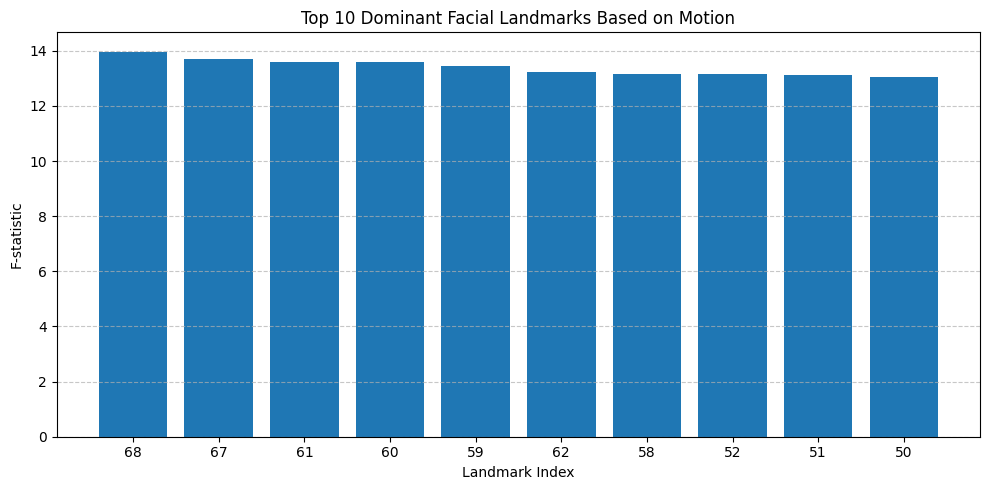

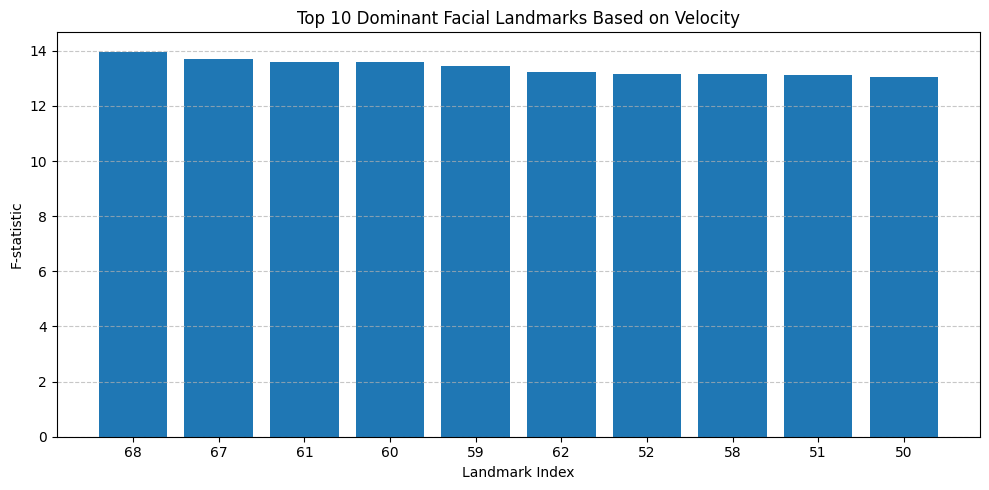

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your ANOVA CSV files
motion_df = pd.read_csv("anova_motion_results.csv")
velocity_df = pd.read_csv("anova_velocity_results.csv")

# Sort and get top 10 landmarks with the most significant p-values
top_motion = motion_df.sort_values(by='p-value').head(10)
top_velocity = velocity_df.sort_values(by='p-value').head(10)

# Plot - Motion
plt.figure(figsize=(10, 5))
plt.bar(top_motion['Landmark Index'].astype(str), top_motion['F-statistic'])
plt.title('Top 10 Dominant Facial Landmarks Based on Motion')
plt.xlabel('Landmark Index')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot - Velocity
plt.figure(figsize=(10, 5))
plt.bar(top_velocity['Landmark Index'].astype(str), top_velocity['F-statistic'])
plt.title('Top 10 Dominant Facial Landmarks Based on Velocity')
plt.xlabel('Landmark Index')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
